# Ejercicio 1

### Introduccion

El dataset que subimos consiste en un diccionario que consta de tres elementos:

`tiempos_disparos` es una lista de 1000 elementos. Cada elemento corresponde a los tiempos de disparo de una neurona (unidades en $s$).

`velocidades` es un vector con valores de velocidad en el tiempo (unidades en $m/s$).

`tiempos_velocidades` es un vector de tiempos correspondiente a cada valor de velocidad (unidades en $s$).

El dataset fue simulado generando un vector de velocidad de forma aleatoria (de tipo *random walk* gaussiano) y trenes de disparos independientes provenientes de un proceso de Poisson no estacionario (para quienes le interese, ya lo vamos a ver pero [aca](https://elephant.readthedocs.io/en/latest/index.html) pueden aprender de una libreria muy piola para hacerlo). Esto ultimo quiere decir que generamos disparos de neuronas independientes mediante distribuciones de Poisson cuyas medias de disparo $\lambda$ variaban en el tiempo en funcion de la velocidad $v$ siguiendo un modelo mas o menos como este



$$\lambda_i(v) = r_i + \alpha_i\left[v-v_{i}^{th}\right]^+ $$

donde la operacion $[\alpha]^+=\alpha$ si $\alpha>0$ y $[\alpha]^+=0$ si $\alpha<0$. Lo importante es que es un modelo de respuesta lineal a la velocidad, algo relativamente verosimil a lo que se ve en varios tipos de neuronas que codifican velocidad en distintas partes del cerebro (aunque bastante muy de juguete).

La idea de este ejercicio es que sea bastante guiado para que tengan un primer appoach algo metodico para ver y aplicar PCA, pero la posta va a estar en el ejercicio 2.

### Importamos librerias utiles (pueden usar las que quieran)

In [1]:
import numpy as np
import matplotlib.pylab as plt

#### Primero, descarguen la data y carguenla en el notebook.

In [2]:
import pickle
mypath = "./" #aca pongan la direccion del archivo

with open(mypath+'DataTP1.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [3]:
tiempos_disparos = data['tiempos_disparos']
tiempos_velocidades = data['tiempos_velocidades']
velocidades = data['velocidades']


In [4]:
# Analisis de los datos
print("Tipos de datos:")
print(" - tiempos_disparos:", type(tiempos_disparos))
print(" - tiempos_velocidades:", type(tiempos_velocidades))
print(" - velocidades:", type(velocidades))

print("\nTipos de datos del primer elemento:")
print(" - tiempos_disparos[0]:", type(tiempos_disparos[0]))
print(" - tiempos_velocidades[0]:", type(tiempos_velocidades[0]))
print(" - velocidades[0]:", type(velocidades[0]))

print("\nDimensiones de los datos:")
print(" - Dimensiones de tiempos_disparos[0]:", tiempos_disparos[0].shape)
print(" - Dimensiones de tiempos_velocidades:", tiempos_velocidades.shape)
print(" - Dimensiones de velocidades:", velocidades.shape)

total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in tiempos_disparos]
print(f"\nNúmero de disparos para las 1ras cinco neuronas: {total_spikes_per_neuron[:5]}")


Tipos de datos:
 - tiempos_disparos: <class 'list'>
 - tiempos_velocidades: <class 'numpy.ndarray'>
 - velocidades: <class 'numpy.ndarray'>

Tipos de datos del primer elemento:
 - tiempos_disparos[0]: <class 'numpy.ndarray'>
 - tiempos_velocidades[0]: <class 'numpy.float64'>
 - velocidades[0]: <class 'numpy.float64'>

Dimensiones de los datos:
 - Dimensiones de tiempos_disparos[0]: (4302,)
 - Dimensiones de tiempos_velocidades: (30001,)
 - Dimensiones de velocidades: (30001,)

Número de disparos para las 1ras cinco neuronas: [4302, 508, 177, 1821, 2363]


## Inciso (a)

- Realizar un rasterplot de los trenes de disparo en el tiempo
- Visualizar velocidad vs. tiempo

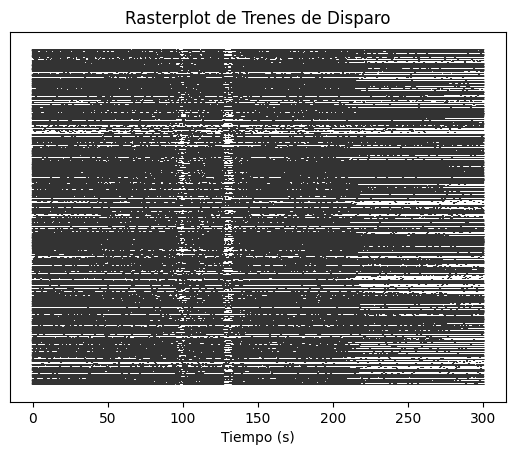

In [5]:
# Realizar un rasterplot de los trenes de disparo en el tiempo

'''
# la trama resultante se vuelva difícil de interpretar debido a la alta densidad de puntos (muchas neuronas)
# Una opcion podria ser seleccionar aleatoriamente 30 neuronas para visualizar

sample_number = 30
sample_neurons_index = np.random.choice(len(tiempos_disparos), sample_number, replace=False)
plt.figure(figsize=(10, 6))
for i in sample_neurons_index:
    spikes = tiempos_disparos[i]
    plt.plot(spikes, [i]*len(spikes), '|')
plt.xlabel('Tiempo (s)')
plt.ylabel('Neurona')
plt.title('Rasterplot de Trenes de Disparo (Muestreo Aleatorio)')
plt.show()
'''

plt.eventplot(tiempos_disparos, color=".2")
plt.xlabel('Tiempo (s)')
plt.title('Rasterplot de Trenes de Disparo')
plt.yticks([]);
plt.show()



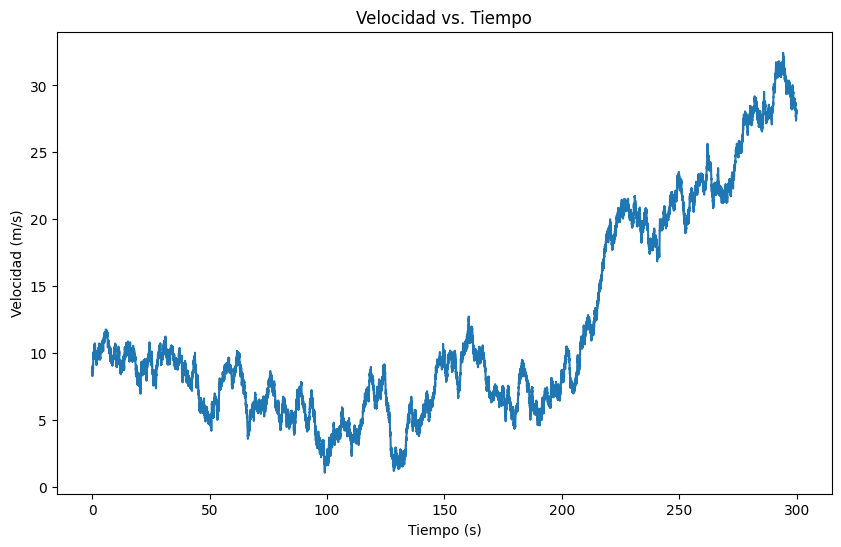

In [6]:
# Visualizar velocidad vs. tiempo
plt.figure(figsize=(10, 6))
plt.plot(tiempos_velocidades, velocidades)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title('Velocidad vs. Tiempo')
plt.show()

## Inciso (b)

Pasar los disparos a tasas de disparo realizando un promedio móvil con una ventana temporal adecuada



In [5]:
#@title Hint

#La idea aca es que bineen la data y sumen la cantidad de disparos por cada bin
#temporal (y lo mismo con el vector de velocidades). Hay muchas formas de hacer-
#lo, aca les dejamos una

#(1) Definan un bin temporal que les parezca razonable. La data esta en segundos,
#asi que una forma de estimar el sampling rate de los datos es calculando la
#media de la diferencia entre tiempos de mediciones consecutivas
dt = np.mean(np.diff(tiempos_velocidades))

N = len(tiempos_disparos) #numero de neuronas

#dado que el dt es de 10ms, promediar de a un segundo nos garantiza juntar varios
#disparos por bin
ancho_bin = 1

#Como los tiempos de las velocidades estan equiespaciados, los sampleamos con el
#ancho elegido
bin_tiempos_velocidades = tiempos_velocidades[::int(ancho_bin/dt)]
bin_velocidades = [np.mean(velocidades[i*int(ancho_bin/dt):(i+1)*int(ancho_bin/dt)]) for i in range(len(bin_tiempos_velocidades)-1)] #velocidad media por bin

#Calculamos y almacenamos las tasas de disparo en una matriz
tasa_disparo = np.zeros((N,len(bin_tiempos_velocidades)-1))
for n in range(tasa_disparo.shape[0]):
  tasa_disparo[n,:], _ = np.histogram(tiempos_disparos[n], bins=bin_tiempos_velocidades)

print("tasa_disparo dimensions:", tasa_disparo.shape)

tasa_disparo dimensions: (1000, 300)


### Inciso (c)

Usando los datos del punto (b), visualizar la respuesta de las neuronas a las distintas velocidades ¿Todas responden de la misma forma?

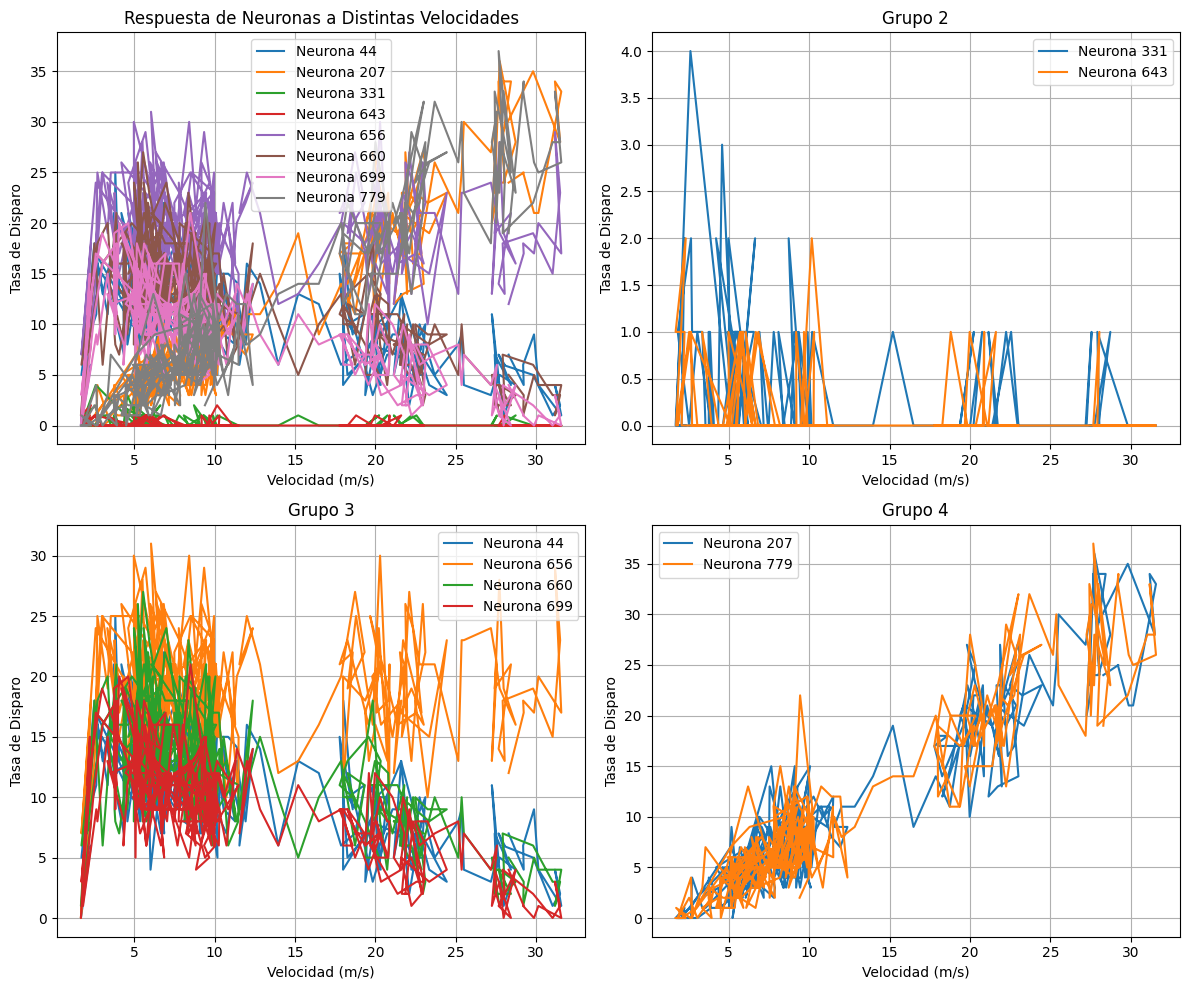

In [8]:
# Define los índices de neuronas para cada grupo
indices_de_neuronas = [44, 207, 331, 643, 656, 660, 699, 779]
grupo1_indices = [331, 643]
grupo2_indices = [44, 656, 660, 699]
grupo3_indices = [207, 779]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (grupo_indices, ax) in enumerate(zip([indices_de_neuronas, grupo1_indices, grupo2_indices, grupo3_indices], axs.flatten()), 1):
    for indice in grupo_indices:
        tasa_neurona = tasa_disparo[indice]
        ax.plot(bin_velocidades, tasa_neurona, label=f'Neurona {indice}')
    ax.set_xlabel('Velocidad (m/s)')
    ax.set_ylabel('Tasa de Disparo')
    if i == 1:
        ax.set_title('Respuesta de Neuronas a Distintas Velocidades')
    else: 
        ax.set_title(f'Grupo {i}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Notemos que no todas las neuronas responden de la misma forma. Algunas responden más a la velocidad como las de índice 207 y 779, otras como la 331 y 643 parece no afectarles la velocidad y otras como la 44, 660 y 699 responden negativamente a la velocidad.

### Inciso (d)

Aplicar PCA sobre los datos del punto b y graficar la varianza explicada cumulativa ¿Cuántas dimensiones esperas que sean necesarias para capturar la dinámica relevante del problema?


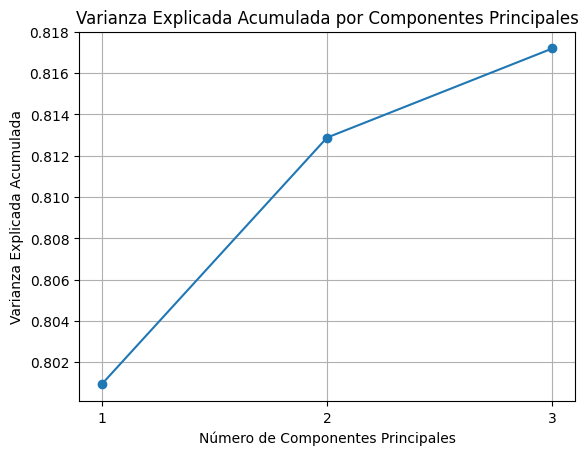

In [8]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(n_components=3)  # Reducir a 3 dimensiones para visualización
tasa_disparo_pca = pca.fit_transform(tasa_disparo.T)  # Transponer matriz para que las muestras estén en filas

# Graficamos la varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1, 1))
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.grid(True)
plt.show()

Si consideramos que la dinámica relevante del problema es la respuesta de las neuronas a la velocidad, esperamos que con dos dimensiones podamos capturar la mayor parte de la varianza.

Notemos que, luego de aplicar PCA, con 2 dimensiones capturamos más del 80% de la varianza.

Sin embargo, no puedo dejar de mencionar que con una sola componente principal capturamos casi el 80% de la varianza. Esto es porque la velocidad es la variable que más influye en la respuesta de las neuronas.

### Inciso (e)

Visualizar en 2D
 - PC1 vs. PC2
 - PC1 vs. Velocidad
 - PC1 vs. tiempo

¿Tiene sentido en base a lo esperado?

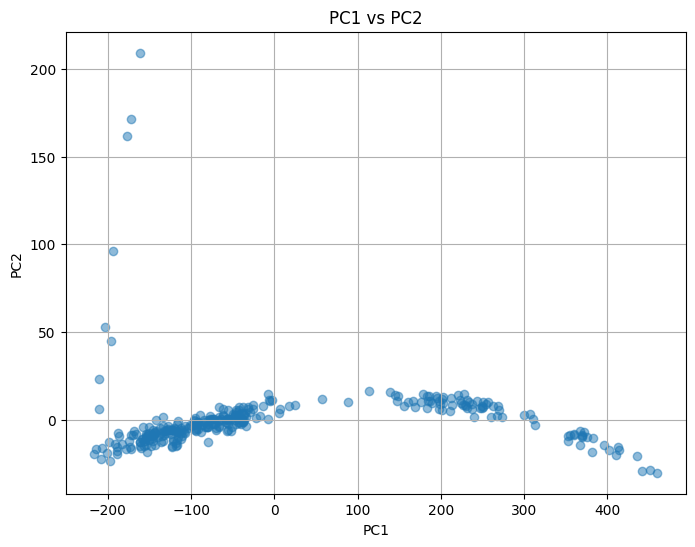

In [7]:
# PCA1 vs PC2
pc1 = tasa_disparo_pca[:, 0]
pc2 = tasa_disparo_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)
plt.show()


Este gráfico muestra claramente lo mencionado en el inciso anterior sobre que la velocidad es la variable que más influye en la respuesta de las neuronas. 

La PC1 captura la mayor parte de la varianza y, como se ve en el gráfico, por lo que la presencia de una medialuna de puntos cerca del eje x (PC1) en el scatter plot sugiere que la variabilidad principal o la estructura dominante en los datos se encuentra a lo largo de esa dimensión.

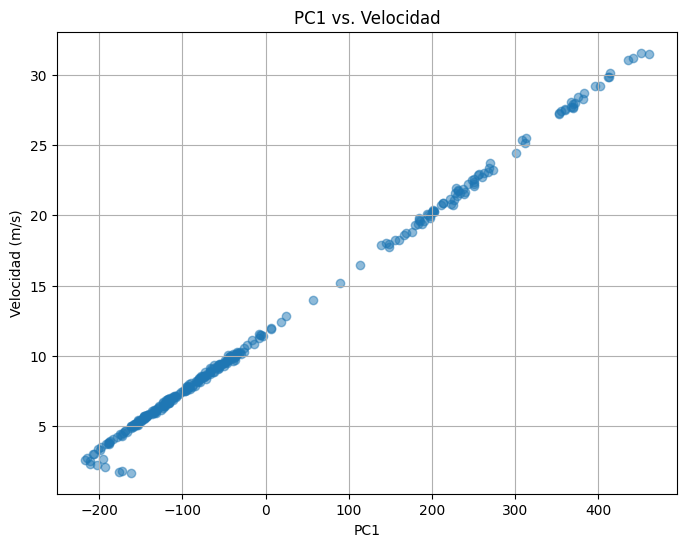

In [26]:
# PC1 vs. Velocidad
plt.figure(figsize=(8, 6))
plt.scatter(tasa_disparo_pca[:, 0], bin_velocidades, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Velocidad (m/s)')
plt.title('PC1 vs. Velocidad')
plt.grid(True)
plt.show()

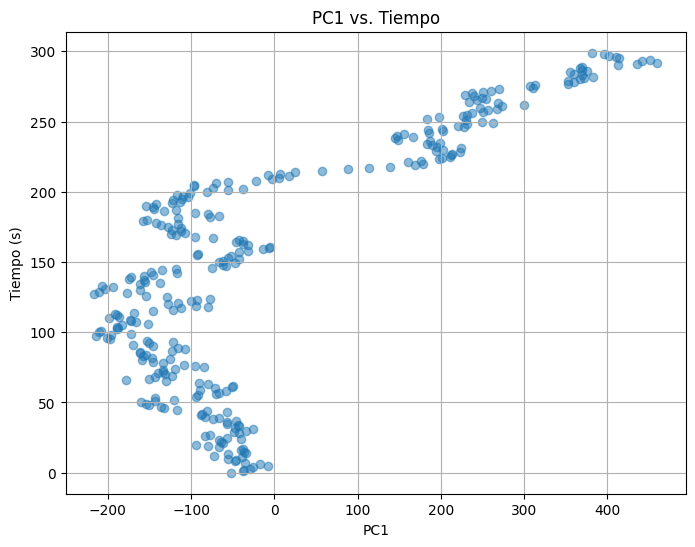

In [27]:
# PC1 vs. Tiempo
plt.figure(figsize=(8, 6))
plt.scatter(tasa_disparo_pca[:, 0], bin_tiempos_velocidades[:-1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Tiempo (s)')
plt.title('PC1 vs. Tiempo')
plt.grid(True)
plt.show()

Por último, en los gráficos de 'PC1 vs velocidad' y 'PC1 vs tiempo' podemos llegar a conclusiones similares. 

Notemos como la nube de puntos en el primer gráfico muestra una relación casi lineal entre PC1 y la velocidad.

Por otro lado, en el segundo gráfico, vemos que la PC1 no tiene una relación clara con el tiempo.

Por lo que podemos concluir que la velocidad es la variable que más influye en la respuesta de las neuronas, y por lo tanto, la que está contribuyendo más significantemente a la variabilidad capturada por la primera componente principal.